In [37]:
# Cell 1: Imports and Augmentation Functions
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.approximation import PiecewiseAggregateApproximation
from PIL import Image
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

In [101]:
# Augmentation functions
def augment_gaussian_noise(signal):
    noise_level = 0.1 * np.std(signal)
    return signal + np.random.normal(0, noise_level, signal.shape)

def augment_time_shift(signal):
    shift = np.random.randint(5, 15)
    return np.pad(signal, (shift, 0), mode='reflect')[:len(signal)]

def augment_amplitude_scale(signal):
    scale = np.random.uniform(0.95, 1.05)
    return signal * scale

In [102]:
import os
os.getcwd()


'C:\\Users\\piyus\\mlenv\\gaitenv\\gait-in-neurodegenerative-disease-database-1.0.0'

In [103]:
# Cell 2: Set Working Directory and Verify .ts Files
import os
import glob

dataset_dir = os.path.normpath("C:/Users/piyus/mlenv/gaitenv/gait-in-neurodegenerative-disease-database-1.0.0")
try:
    os.chdir(dataset_dir)
    print(f"Changed working directory to: {os.getcwd()}")
    
    # Verify .ts files for each class
    class_prefixes = {'als': 'ALS', 'cont': 'Control', 'hunt': 'Huntington’s', 'park': 'Parkinson’s'}
    ts_files = glob.glob("*.ts")
    if not ts_files:
        print("Warning: No .ts files found in the directory.")
    
    # Count .ts files per class
    class_counts = {prefix: 0 for prefix in class_prefixes}
    for ts_file in ts_files:
        for prefix in class_prefixes:
            if ts_file.startswith(prefix):
                class_counts[prefix] += 1
                break
    
    print("Found .ts files per class:")
    for prefix, name in class_prefixes.items():
        count = class_counts[prefix]
        print(f"{name}: {count} .ts files")
        if count == 0:
            print(f"Warning: No .ts files found for {name} (prefix: {prefix}).")
    
except FileNotFoundError:
    print(f"Error: Directory '{dataset_dir}' not found. Please check the path.")
    raise
except PermissionError:
    print(f"Error: Permission denied for directory '{dataset_dir}'.")
    raise
except Exception as e:
    print(f"Error changing directory: {e}")
    raise

Changed working directory to: C:\Users\piyus\mlenv\gaitenv\gait-in-neurodegenerative-disease-database-1.0.0
Found .ts files per class:
ALS: 13 .ts files
Control: 16 .ts files
Huntington’s: 20 .ts files
Parkinson’s: 15 .ts files


In [104]:
# Cell 3: Load Subject Description and Verify
import pandas as pd
import os

try:
    # Load subject description
    subject_file = os.path.join(os.getcwd(), "subject-description.txt")
    subject_info = pd.read_csv(subject_file, sep="\t")
    print("Subject description loaded successfully.")
    print("\nFirst few rows:")
    print(subject_info.head())
    print("\nColumn names:", list(subject_info.columns))
    print("Data types:\n", subject_info.dtypes)
    
    # Verify expected columns
    expected_columns = ['Unnamed: 0', 'GROUP']
    missing_columns = [col for col in expected_columns if col not in subject_info.columns]
    if missing_columns:
        print(f"Warning: Missing expected columns: {missing_columns}")
    else:
        print("All expected columns found.")
    
    # Verify number of subjects
    num_subjects = len(subject_info)
    if num_subjects < 60 or num_subjects > 70:
        print(f"Warning: Unexpected number of subjects ({num_subjects}), expected ~64.")
    else:
        print(f"Number of subjects: {num_subjects}")
    
    # Define class mapping (lowercase to match data)
    class_mapping = {
        'als': 0,
        'control': 1,
        'hunt': 2,
        'park': 3
    }
    
    # Verify groups and count subjects per group
    if 'GROUP' in subject_info.columns:
        unique_groups = subject_info['GROUP'].unique()
        print(f"Unique groups found: {unique_groups}")
        group_counts = subject_info['GROUP'].value_counts()
        print("\nSubjects per group:")
        for group, count in group_counts.items():
            print(f"{group}: {count} subjects")
            if group not in class_mapping:
                print(f"Warning: Unknown group '{group}' in subject description.")
    else:
        print("Warning: 'GROUP' column not found, cannot verify class labels.")
    
except FileNotFoundError:
    print(f"Error: 'subject-description.txt' not found at '{subject_file}'. Check the file path.")
    raise
except pd.errors.ParserError:
    print(f"Error: Failed to parse 'subject-description.txt'. Check file format.")
    raise
except Exception as e:
    print(f"Error loading subject description: {e}")
    raise

Subject description loaded successfully.

First few rows:
  Unnamed: 0    GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0   control1  control        57            1.94         95      f   
1   control2  control        22            1.94         70      m   
2   control3  control        23            1.83         66      f   
3   control4  control        52            1.78         73      f   
4   control5  control        47            1.94         82      f   

  GaitSpeed(m/sec)  Duration/Severity  
0             1.33                0.0  
1             1.47                0.0  
2             1.44                0.0  
3             1.54                0.0  
4             1.54                0.0  

Column names: ['Unnamed: 0', 'GROUP', 'AGE(YRS)', 'HEIGHT(meters)', 'Weight(kg)', 'gender', 'GaitSpeed(m/sec)', 'Duration/Severity']
Data types:
 Unnamed: 0            object
GROUP                 object
AGE(YRS)               int64
HEIGHT(meters)       float64
Weight(kg)            ob

In [105]:
# Cell 4: Find and Verify .ts Files
import glob
import os

# Find .ts files
ts_files = glob.glob("*.ts")
print(f"Total .ts files found: {len(ts_files)}")

# Verify count
expected_files = 64
if len(ts_files) == 0:
    raise FileNotFoundError("No .ts files found in the directory.")
elif len(ts_files) != expected_files:
    print(f"Warning: Found {len(ts_files)} .ts files, expected {expected_files}.")

# Sort files
ts_files.sort()

# Cross-check with subject_info
global subject_info  # Assumes subject_info from Cell 3
if 'subject_info' in globals():
    subject_ids = subject_info['Unnamed: 0'].str.lower().tolist()  # E.g., als1, control1
    ts_basenames = [os.path.splitext(os.path.basename(f))[0].lower() for f in ts_files]  # E.g., als1
    missing_ids = [sid for sid in subject_ids if sid not in ts_basenames]
    extra_files = [f for f in ts_basenames if f not in subject_ids]
    if missing_ids:
        print(f"Warning: Subject IDs missing corresponding .ts files: {missing_ids}")
    if extra_files:
        print(f"Warning: Extra .ts files not in subject_info: {extra_files}")
    print(f"Sample .ts files: {ts_files[:5]}")  # Show first 5 for verification
else:
    print("Warning: subject_info not found, cannot cross-check .ts files with subject IDs.")

# Group files by class
class_mapping = {'als': 'als', 'control': 'control', 'hunt': 'hunt', 'park': 'park'}
ts_files_by_class = {cls: [] for cls in class_mapping}
for ts_file in ts_files:
    basename = os.path.splitext(os.path.basename(ts_file))[0].lower()
    for prefix in class_mapping:
        if basename.startswith(prefix):
            ts_files_by_class[prefix].append(ts_file)
            break
print("\n.ts files per class:")
for cls, files in ts_files_by_class.items():
    print(f"{class_mapping[cls].capitalize()}: {len(files)} .ts files")

Total .ts files found: 64
Sample .ts files: ['als1.ts', 'als10.ts', 'als11.ts', 'als12.ts', 'als13.ts']

.ts files per class:
Als: 13 .ts files
Control: 16 .ts files
Hunt: 20 .ts files
Park: 15 .ts files


In [106]:
# Cell 5: Load and Augment .ts Files
import re
import pandas as pd
import numpy as np
import os

data_dict = {}  # Stores augmented signals and metadata
output_dir = os.path.join(os.getcwd(), "gaf_images_augmented")
os.makedirs(output_dir, exist_ok=True)

# Feature columns (excluding Time)
feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", 
    "L_Swing%", "R_Swing%", "L_Stance", "R_Stance", 
    "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]

for file in ts_files:
    subject_id = os.path.basename(file).replace(".ts", "")
    try:
        # Read .ts file
        ts_data = pd.read_csv(file, sep=r"\s+", header=None)
        ts_data.columns = ["Time"] + feature_columns
        if ts_data.isnull().any().any():
            ts_data = ts_data.interpolate()
            print(f"Interpolated missing values for {subject_id}")
        
        # Match with subject_info
        subj_info_row = subject_info[subject_info["Unnamed: 0"] == subject_id]
        if not subj_info_row.empty:
            if "GROUP" in subject_info.columns:
                group = subj_info_row["GROUP"].iloc[0].lower()
                print(f"Using GROUP from subject_info for {subject_id}: {group}")
            else:
                match = re.match(r"([a-z]+)", subject_id.lower())
                group = match.group(1) if match else "unknown"
                print(f"Extracted group for {subject_id}: {group}")
            
            # Create class directory
            class_dir = os.path.join(output_dir, group)
            os.makedirs(class_dir, exist_ok=True)
            
            # Augment each feature
            augmented_signals = {}
            for feature in feature_columns:
                signal = ts_data[feature].values
                # Original signal
                augmented_signals[f"{feature}_original"] = signal
                # Augmented signals
                augmented_signals[f"{feature}_noise"] = augment_gaussian_noise(signal)
                augmented_signals[f"{feature}_shift"] = augment_time_shift(signal)
                augmented_signals[f"{feature}_scale"] = augment_amplitude_scale(signal)
            
            # Store in data_dict
            data_dict[subject_id] = {
                "group": group,
                "signals": augmented_signals,  # {L_Stride_original, L_Stride_noise, ...}
                "info": subj_info_row.to_dict(orient="records")[0]
            }
            
            # Create feature directories
            for feature in feature_columns:
                feature_dir = os.path.join(class_dir, feature)
                os.makedirs(feature_dir, exist_ok=True)
                
        else:
            print(f"Warning: {subject_id} not found in subject-description.txt")
            continue
            
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

print(f"Processed {len(data_dict)} subjects into data_dict.")

Using GROUP from subject_info for als1: als
Using GROUP from subject_info for als10: als
Using GROUP from subject_info for als11: als
Using GROUP from subject_info for als12: als
Using GROUP from subject_info for als13: als
Using GROUP from subject_info for als2: als
Using GROUP from subject_info for als3: als
Using GROUP from subject_info for als4: als
Using GROUP from subject_info for als5: als
Using GROUP from subject_info for als6: als
Using GROUP from subject_info for als7: als
Using GROUP from subject_info for als8: als
Using GROUP from subject_info for als9: als
Using GROUP from subject_info for control1: control
Using GROUP from subject_info for control10: control
Using GROUP from subject_info for control11: control
Using GROUP from subject_info for control12: control
Using GROUP from subject_info for control13: control
Using GROUP from subject_info for control14: control
Using GROUP from subject_info for control15: control
Using GROUP from subject_info for control16: control
U


Verifying subject: als1 (Group: ALS)

Subject Info:
  Unnamed: 0 GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0       als1   als        68           1.803      86.18      m   

  GaitSpeed(m/sec)  Duration/Severity  
0            1.302                1.0  

Sample Signal (L_Stride):
Original:
  Length: 194
  First 5 values: [1.2833 1.3233 1.3033 1.4167 1.2367]
  Contains NaN: False
  Min: 1.1167, Max: 5.6667
Noise:
  Length: 194
  First 5 values: [1.27310381 1.28558947 1.3185786  1.40149189 1.26675862]
  Contains NaN: False
  Min: 1.0707746380700307, Max: 5.711472340944535
Shift:
  Length: 194
  First 5 values: [1.2067 1.3367 1.2367 1.4167 1.3033]
  Contains NaN: False
  Min: 1.1167, Max: 5.6667
Scale:
  Length: 194
  First 5 values: [1.22891024 1.26721493 1.24806259 1.35665639 1.18428528]
  Contains NaN: False
  Min: 1.0693712054651348, Max: 5.426529784193856


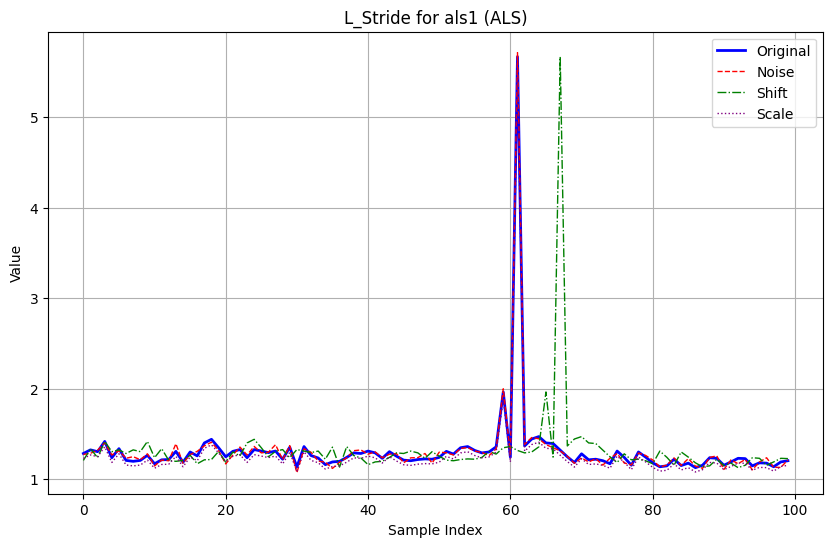


Verifying subject: control1 (Group: Control)

Subject Info:
  Unnamed: 0    GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0   control1  control        57            1.94         95      f   

  GaitSpeed(m/sec)  Duration/Severity  
0             1.33                0.0  

Sample Signal (L_Stride):
Original:
  Length: 259
  First 5 values: [1.0667 1.0867 1.0467 1.05   1.0167]
  Contains NaN: False
  Min: 0.9633, Max: 1.3967
Noise:
  Length: 259
  First 5 values: [1.07100397 1.08310492 1.05126885 1.05592003 1.012768  ]
  Contains NaN: False
  Min: 0.9569766087391799, Max: 1.3996863108514
Shift:
  Length: 259
  First 5 values: [1.0467 1.0367 1.0633 1.0567 1.02  ]
  Contains NaN: False
  Min: 0.9633, Max: 1.3967
Scale:
  Length: 259
  First 5 values: [1.02535153 1.04457627 1.00612679 1.00929887 0.97728968]
  Contains NaN: False
  Min: 0.9259596211208414, Max: 1.3425597454785416


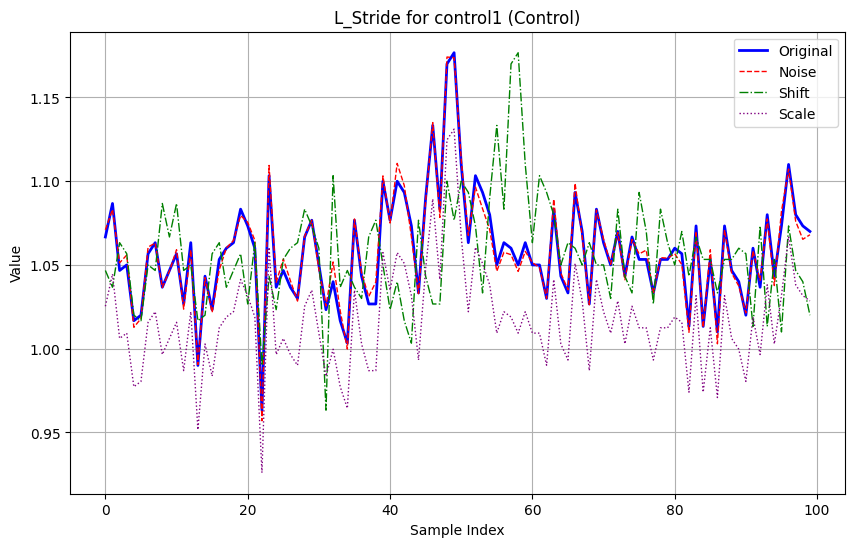


Verifying subject: hunt1 (Group: Huntington’s)

Subject Info:
  Unnamed: 0 GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0      hunt1  hunt        42            1.86         72      m   

  GaitSpeed(m/sec)  Duration/Severity  
0             1.68                8.0  

Sample Signal (L_Stride):
Original:
  Length: 310
  First 5 values: [0.9033 0.8567 0.95   0.9867 0.8833]
  Contains NaN: False
  Min: 0.75, Max: 1.3167
Noise:
  Length: 310
  First 5 values: [0.90261843 0.84516954 0.95707017 0.97819431 0.88906189]
  Contains NaN: False
  Min: 0.7528667967076224, Max: 1.3174783936153938
Shift:
  Length: 310
  First 5 values: [0.9267 0.9167 0.9467 0.9533 0.9033]
  Contains NaN: False
  Min: 0.75, Max: 1.3167
Scale:
  Length: 310
  First 5 values: [0.88002318 0.834624   0.92551979 0.96127408 0.86053856]
  Contains NaN: False
  Min: 0.7306735166028726, Max: 1.2827704257480033


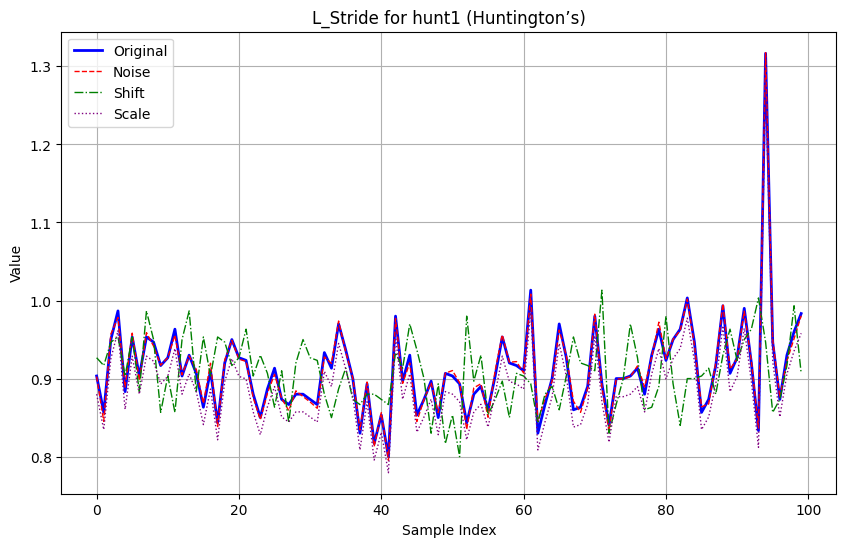


Verifying subject: park1 (Group: Parkinson’s)

Subject Info:
  Unnamed: 0 GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0      park1  park        77             2.0         86      m   

  GaitSpeed(m/sec)  Duration/Severity  
0             0.98                4.0  

Sample Signal (L_Stride):
Original:
  Length: 245
  First 5 values: [1.1333 1.1067 1.2067 1.0833 1.1767]
  Contains NaN: False
  Min: 1.0133, Max: 1.3033
Noise:
  Length: 245
  First 5 values: [1.12856807 1.10428555 1.20681165 1.08402092 1.17347233]
  Contains NaN: False
  Min: 1.0185469636822695, Max: 1.3021701869904694
Shift:
  Length: 245
  First 5 values: [1.1133 1.1    1.0667 1.1767 1.0833]
  Contains NaN: False
  Min: 1.0133, Max: 1.3033
Scale:
  Length: 245
  First 5 values: [1.1114676  1.08538004 1.18345359 1.06243082 1.15403153]
  Contains NaN: False
  Min: 0.9937793362526731, Max: 1.278192646736513


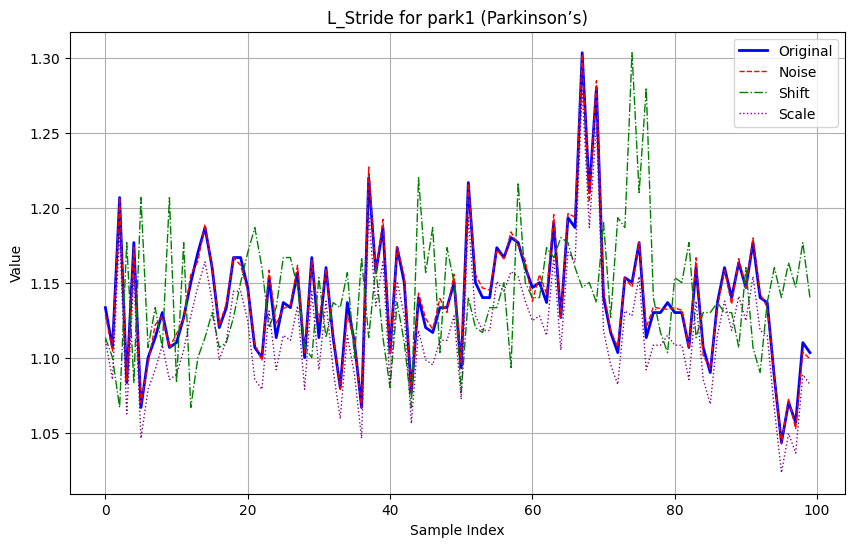

In [107]:
# Cell 6: Verify Augmented Signals
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
    raise ValueError("data_dict is empty.")

# Check one subject per class
class_mapping = {'als': 'ALS', 'control': 'Control', 'hunt': 'Huntington’s', 'park': 'Parkinson’s'}
sample_subjects = {}
for subject_id, data in data_dict.items():
    group = data['group']
    if group in class_mapping and group not in sample_subjects:
        sample_subjects[group] = subject_id
    if len(sample_subjects) == len(class_mapping):
        break

if not sample_subjects:
    print("Error: No valid subjects found in data_dict.")
    raise ValueError("No valid subjects.")

for group, subject_id in sample_subjects.items():
    try:
        sample = data_dict[subject_id]
        print(f"\nVerifying subject: {subject_id} (Group: {class_mapping[group]})")
        print("\nSubject Info:")
        print(pd.DataFrame([sample['info']]))
        
        # Display sample signal (L_Stride)
        feature = "L_Stride"
        print(f"\nSample Signal ({feature}):")
        signals = {
            "Original": sample['signals'][f"{feature}_original"],
            "Noise": sample['signals'][f"{feature}_noise"],
            "Shift": sample['signals'][f"{feature}_shift"],
            "Scale": sample['signals'][f"{feature}_scale"]
        }
        
        # Check signal integrity
        for name, signal in signals.items():
            print(f"{name}:")
            print(f"  Length: {len(signal)}")
            print(f"  First 5 values: {signal[:5]}")
            print(f"  Contains NaN: {np.isnan(signal).any()}")
            print(f"  Min: {np.nanmin(signal)}, Max: {np.nanmax(signal)}")
        
        # Plot signals
        plt.figure(figsize=(10, 6))
        plot_length = min(100, min(len(signal) for signal in signals.values()))
        styles = {
            "Original": {"color": "blue", "linestyle": "-", "linewidth": 2},
            "Noise": {"color": "red", "linestyle": "--", "linewidth": 1},
            "Shift": {"color": "green", "linestyle": "-.", "linewidth": 1},
            "Scale": {"color": "purple", "linestyle": ":", "linewidth": 1}
        }
        for name, signal in signals.items():
            plt.plot(signal[0:100], label=name, **styles[name])
        plt.title(f"{feature} for {subject_id} ({class_mapping[group]})")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except KeyError as e:
        print(f"Error: Issue with {subject_id}: {e}")

In [108]:
# Cell 7: Check for Missing Values in Augmented Signals
import numpy as np

if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
    raise ValueError("data_dict is empty.")

feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", 
    "L_Swing%", "R_Swing%", "L_Stance", "R_Stance", 
    "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]
augmentation_types = ["original", "noise", "shift", "scale"]

print("Checking for missing values in augmented signals...")
missing_values_found = False
for sid, record in data_dict.items():
    signals = record["signals"]
    for feature in feature_columns:
        for aug_type in augmentation_types:
            signal_key = f"{feature}_{aug_type}"
            signal = signals[signal_key]
            if np.isnan(signal).any():
                print(f"Missing values in {signal_key} for subject: {sid}")
                missing_values_found = True

if not missing_values_found:
    print("No missing values found in any augmented signals.")
else:
    print("Warning: Missing values detected. Consider revising interpolation in previous steps.")

Checking for missing values in augmented signals...
No missing values found in any augmented signals.


In [109]:
# Cell 8: Validate data_dict Entries
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
    raise ValueError("data_dict is empty.")

feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", 
    "L_Swing%", "R_Swing%", "L_Stance", "R_Stance", 
    "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]
augmentation_types = ["original", "noise", "shift", "scale"]
expected_signal_keys = {f"{feature}_{aug_type}" for feature in feature_columns for aug_type in augmentation_types}

print("Validating data_dict entries...")
required_keys = {"group", "info", "signals"}
validation_issues = False

for sid, record in data_dict.items():
    # Check top-level keys
    missing_keys = required_keys - set(record.keys())
    if missing_keys:
        print(f"Incomplete entry for {sid}: Missing keys {missing_keys}")
        validation_issues = True
        continue
    
    # Validate signals dictionary
    signals = record["signals"]
    missing_signals = expected_signal_keys - set(signals.keys())
    if missing_signals:
        print(f"Incomplete signals for {sid}: Missing signal keys {missing_signals}")
        validation_issues = True
    else:
        print(f"Complete entry for {sid}")

if not validation_issues:
    print(f"All {len(data_dict)} entries validated successfully.")
else:
    print("Warning: Validation issues detected. Check the errors above.")

Validating data_dict entries...
Complete entry for als1
Complete entry for als10
Complete entry for als11
Complete entry for als12
Complete entry for als13
Complete entry for als2
Complete entry for als3
Complete entry for als4
Complete entry for als5
Complete entry for als6
Complete entry for als7
Complete entry for als8
Complete entry for als9
Complete entry for control1
Complete entry for control10
Complete entry for control11
Complete entry for control12
Complete entry for control13
Complete entry for control14
Complete entry for control15
Complete entry for control16
Complete entry for control2
Complete entry for control3
Complete entry for control4
Complete entry for control5
Complete entry for control6
Complete entry for control7
Complete entry for control8
Complete entry for control9
Complete entry for hunt1
Complete entry for hunt10
Complete entry for hunt11
Complete entry for hunt12
Complete entry for hunt13
Complete entry for hunt14
Complete entry for hunt15
Complete entry f

In [110]:
# Cell 9: List and Validate Samples in data_dict
if not data_dict:
    print("Error: data_dict is empty. No samples to list.")
    raise ValueError("data_dict is empty.")

# Optimize subject_info lookup
subject_ids = set(subject_info["Unnamed: 0"].values)

# Expected counts per group (from Cell 3 output)
expected_counts = {"als": 13, "control": 16, "hunt": 20, "park": 15}

print(f"Listing all {len(data_dict)} samples in data_dict:")
print(f"{'Subject ID':<15} {'Group':<10} {'In subject_info':<15}")
print("-" * 40)

# Sort and list samples
sorted_samples = sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0]))
group_counts = {"als": 0, "control": 0, "hunt": 0, "park": 0}
missing_in_subject_info = []

for sid, record in sorted_samples:
    group = record["group"]
    in_subject_info = "Yes" if sid in subject_ids else "No"
    print(f"{sid:<15} {group:<10} {in_subject_info:<15}")
    group_counts[group] += 1
    if in_subject_info == "No":
        missing_in_subject_info.append(sid)

# Summarize
print(f"\nTotal samples: {len(data_dict)} (expected 64)")
if len(data_dict) != 64:
    print(f"Warning: Number of samples ({len(data_dict)}) does not match expected (64).")

print("\nSubjects per group:")
for group, count in group_counts.items():
    expected = expected_counts.get(group, 0)
    print(f"{group}: {count} (expected {expected})")
    if count != expected:
        print(f"Warning: Mismatch in {group} count.")

if missing_in_subject_info:
    print(f"\nWarning: {len(missing_in_subject_info)} subjects not found in subject_info: {missing_in_subject_info}")
else:
    print("\nAll subjects found in subject_info.")

Listing all 64 samples in data_dict:
Subject ID      Group      In subject_info
----------------------------------------
als1            als        Yes            
als10           als        Yes            
als11           als        Yes            
als12           als        Yes            
als13           als        Yes            
als2            als        Yes            
als3            als        Yes            
als4            als        Yes            
als5            als        Yes            
als6            als        Yes            
als7            als        Yes            
als8            als        Yes            
als9            als        Yes            
control1        control    Yes            
control10       control    Yes            
control11       control    Yes            
control12       control    Yes            
control13       control    Yes            
control14       control    Yes            
control15       control    Yes            
control16       con

In [111]:
# Cell 10: Analyze Signal Length and Consistency
if not data_dict:
    print("Error: data_dict is empty. No samples to analyze.")
    raise ValueError("data_dict is empty.")

feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
    "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]
augmentation_types = ["original", "noise", "shift", "scale"]

print(f"Analyzing signal length and consistency for {len(data_dict)} samples:")
print(f"{'Subject ID':<15} {'Group':<10} {'Signal Length':<15} {'Features Consistent':<20}")
print("-" * 60)

# Track lengths for summary
group_lengths = {"als": [], "control": [], "hunt": [], "park": []}

for sid, record in sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0])):
    group = record["group"]
    signals = record["signals"]
    try:
        # Use L_Stride_original as reference for signal length
        reference_signal = signals["L_Stride_original"]
        signal_length = len(reference_signal)
        
        # Check consistency: all signals should have the same length
        consistent = True
        for feature in feature_columns:
            for aug_type in augmentation_types:
                signal_key = f"{feature}_{aug_type}"
                if len(signals[signal_key]) != signal_length:
                    consistent = False
                    break
            if not consistent:
                break
        
        print(f"{sid:<15} {group:<10} {signal_length:<15} {str(consistent):<20}")
        group_lengths[group].append(signal_length)
        
    except Exception as e:
        print(f"Error processing {sid}: {e}")

# Summarize
print(f"\nTotal samples analyzed: {len(data_dict)} (expected 64)")
if len(data_dict) != 64:
    print(f"Warning: Number of samples ({len(data_dict)}) does not match expected (64).")

print("\nAverage signal length per group:")
for group, lengths in group_lengths.items():
    if lengths:
        avg_length = sum(lengths) / len(lengths)
        print(f"{group}: {avg_length:.2f} samples")
    else:
        print(f"{group}: No samples")

Analyzing signal length and consistency for 64 samples:
Subject ID      Group      Signal Length   Features Consistent 
------------------------------------------------------------
als1            als        194             True                
als10           als        246             True                
als11           als        229             True                
als12           als        122             True                
als13           als        183             True                
als2            als        242             True                
als3            als        215             True                
als4            als        135             True                
als5            als        205             True                
als6            als        176             True                
als7            als        159             True                
als8            als        232             True                
als9            als        212             True    

In [112]:
# Cell 11: Generate RGB GAF Images with Augmentations
import os
import numpy as np
from pyts.image import GramianAngularField
from pyts.approximation import PiecewiseAggregateApproximation
from PIL import Image

output_dir = os.path.join(os.getcwd(), "gaf_images_augmented")
if not data_dict:
    print("Error: data_dict is empty. Cannot generate GAF images.")
    raise ValueError("data_dict is empty.")

feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
    "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]
augmentation_types = ["original", "noise", "shift", "scale"]

print(f"Generating RGB GAF images (224x224) for {len(data_dict)} subjects, {len(feature_columns)} features, {len(augmentation_types)} versions each...")
total_images = 0
skipped = []

for sid, record in sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0])):
    group = record["group"]
    signals = record["signals"]
    
    for column_name in feature_columns:
        for aug_type in augmentation_types:
            signal_key = f"{column_name}_{aug_type}"
            try:
                signal = signals[signal_key]
                
                # Skip if signal is empty or invalid
                if signal.size == 0 or not np.isfinite(signal).all():
                    skipped.append((sid, signal_key, "Invalid data"))
                    continue
                
                # Pad short signals to at least 224 points
                if signal.size < 224:
                    pad_length = 224 - signal.size
                    signal = np.pad(signal, (0, pad_length), mode='edge')
                    print(f"Padded {sid}, {signal_key} from {signal.size-pad_length} to 224 points")
                
                # Apply PAA to get exactly 224 points
                paa = PiecewiseAggregateApproximation(window_size=None, output_size=224)
                signal_resampled = paa.fit_transform(signal.reshape(1, -1))[0]
                
                # Verify resampled length
                if len(signal_resampled) != 224:
                    skipped.append((sid, signal_key, f"Resampled to {len(signal_resampled)} points, expected 224"))
                    continue
                
                # Normalize to [-1, 1]
                if np.max(signal_resampled) != np.min(signal_resampled):
                    signal_normalized = 2 * ((signal_resampled - np.min(signal_resampled)) / 
                                            (np.max(signal_resampled) - np.min(signal_resampled))) - 1
                else:
                    signal_normalized = np.zeros_like(signal_resampled)
                    print(f"Warning: {signal_key} for {sid} is constant, normalized to zeros")
                
                # Apply GASF
                gaf_sum = GramianAngularField(method='summation')
                gasf_image = gaf_sum.fit_transform(signal_normalized.reshape(1, -1))[0]
                
                # Apply GADF
                gaf_diff = GramianAngularField(method='difference')
                gadf_image = gaf_diff.fit_transform(signal_normalized.reshape(1, -1))[0]
                
                # Compute blue channel: absolute difference
                blue_channel = np.abs(signal_normalized[:, None] - signal_normalized[None, :]) / 2
                
                # Verify image shapes (should be 224x224 after PAA)
                if gasf_image.shape != (224, 224):
                    gasf_image = np.array(Image.fromarray(gasf_image).resize((224, 224), Image.Resampling.LANCZOS))
                    print(f"Resized GASF for {sid}, {signal_key} to (224, 224)")
                if gadf_image.shape != (224, 224):
                    gadf_image = np.array(Image.fromarray(gadf_image).resize((224, 224), Image.Resampling.LANCZOS))
                    print(f"Resized GADF for {sid}, {signal_key} to (224, 224)")
                if blue_channel.shape != (224, 224):
                    blue_channel = np.array(Image.fromarray(blue_channel).resize((224, 224), Image.Resampling.LANCZOS))
                    print(f"Resized Blue channel for {sid}, {signal_key} to (224, 224)")
                
                # Normalize GASF and GADF to [0, 1]
                gasf_norm = (gasf_image - gasf_image.min()) / (gasf_image.max() - gasf_image.min())
                gadf_norm = (gadf_image - gadf_image.min()) / (gadf_image.max() - gadf_image.min())
                
                # Create RGB image
                rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
                rgb_image[:, :, 0] = (gasf_norm * 255).astype(np.uint8)  # Red: GASF
                rgb_image[:, :, 1] = (gadf_norm * 255).astype(np.uint8)  # Green: GADF
                rgb_image[:, :, 2] = (blue_channel * 255).astype(np.uint8)  # Blue: Abs diff
                
                # Save image
                feature_dir = os.path.join(output_dir, group, column_name)
                if aug_type == "original":
                    image_name = f"{sid}.png"
                else:
                    image_name = f"{aug_type}_{sid}.png"
                image_path = os.path.join(feature_dir, image_name)
                
                Image.fromarray(rgb_image).save(image_path)
                total_images += 1
                if total_images % 500 == 0:
                    print(f"Saved {total_images} images...")
                
            except Exception as e:
                skipped.append((sid, signal_key, str(e)))
                print(f"Error processing {sid}, {signal_key}: {e}")

print(f"\nTotal RGB GAF images generated: {total_images} (expected {len(data_dict) * len(feature_columns) * len(augmentation_types)})")
if total_images != 3072:
    print(f"Warning: Expected 3072 images (64 subjects × 12 features × 4 versions), but saved {total_images}.")
if skipped:
    print("\nSkipped subjects/features:")
    for sid, feat, reason in skipped:
        print(f"{sid}, {feat}: {reason}")

Generating RGB GAF images (224x224) for 64 subjects, 12 features, 4 versions each...
Padded als1, L_Stride_original from 194 to 224 points
Padded als1, L_Stride_noise from 194 to 224 points
Padded als1, L_Stride_shift from 194 to 224 points
Padded als1, L_Stride_scale from 194 to 224 points
Padded als1, R_Stride_original from 194 to 224 points
Padded als1, R_Stride_noise from 194 to 224 points
Padded als1, R_Stride_shift from 194 to 224 points
Padded als1, R_Stride_scale from 194 to 224 points
Padded als1, L_Swing_original from 194 to 224 points
Padded als1, L_Swing_noise from 194 to 224 points
Padded als1, L_Swing_shift from 194 to 224 points
Padded als1, L_Swing_scale from 194 to 224 points
Padded als1, R_Swing_original from 194 to 224 points
Padded als1, R_Swing_noise from 194 to 224 points
Padded als1, R_Swing_shift from 194 to 224 points
Padded als1, R_Swing_scale from 194 to 224 points
Padded als1, L_Swing%_original from 194 to 224 points
Padded als1, L_Swing%_noise from 194 to 2